## Regression with SciPy Griddata vs ANN

https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.griddata.html

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import Adadelta, Adam
np.random.seed(2018)


Using TensorFlow backend.


### Sample generation

In [2]:
def func(x1, x2):
    """3D - Target function"""
    return x1*(1-x1)*np.cos(4*np.pi*x1) * np.sin(4*np.pi*x2**2)**2

def get_samples(N):
    X = np.random.rand(N, 2)  # N x 2
    y = func(X[:, 0], X[:, 1])  # N x 1
    return X, y
    
# Train data set
X_train, y_train = get_samples(1000)

# Grid data for testing
n = 100
grid_x1, grid_x2 = np.mgrid[0:1:100j, 0:1:100j]

X_test = np.vstack((grid_x1.flatten(), grid_x2.flatten())).T
y_test = func(X_test[:, 0], X_test[:, 1])

### Take a look at the target function

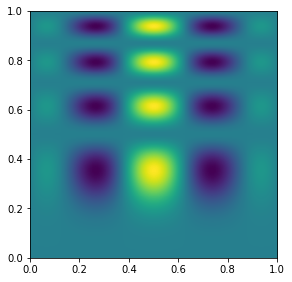

In [3]:
plt.subplot(224)
plt.imshow(func(*np.mgrid[0:1:1000j, 0:1:1000j]).T, extent=(0,1,0,1), origin='lower')
gcf = plt.gcf()
gcf.set_size_inches(10, 10);

# Training

### Scikit-learn MLP

In [4]:
kwargs = dict(hidden_layer_sizes=[128, 64, 32, 16], solver='lbfgs', max_iter=20000, batch_size=1000, random_state=2018)

scikit_model = MLPRegressor(activation="relu", **kwargs)

%time scikit_model.fit(X_train, y_train)
%time res_sklearn = scikit_model.predict(X_test).reshape((n, n))

CPU times: user 24.1 s, sys: 28.3 s, total: 52.5 s
Wall time: 6.6 s
CPU times: user 168 ms, sys: 104 ms, total: 272 ms
Wall time: 34.2 ms


### Keras MLP

In [5]:
activation='tanh'
hidden_layer_sizes=[128, 64, 32, 16]

keras_model = Sequential()
 
keras_model.add(Dense(hidden_layer_sizes[0], activation=activation, input_shape=(2, )))

for hl_size in hidden_layer_sizes[1: ]:
    keras_model.add(Dense(hl_size, activation=activation))

keras_model.add(Dense(1))
keras_model.compile(loss='mean_squared_error', optimizer=Adam())
keras_model.save_weights('cache.h5')
keras_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________


In [6]:
keras_model.load_weights('cache.h5')  # re-initialize Keras model weights
keras_history = keras_model.fit(X_train, y_train, batch_size=1000, epochs=20000, verbose=0)
res_keras=keras_model.predict(X_test).reshape((n, n))

### Training Visualisation

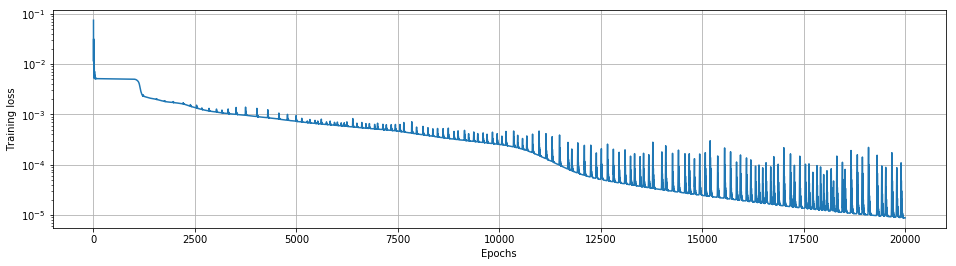

In [7]:
plt.figure(figsize=(16,4))
plt.semilogy(keras_history.history['loss'])
plt.ylabel("Training loss")
plt.xlabel("Epochs")
plt.grid();

### Griddata Interpolation

In [8]:
res_griddata = griddata(points=X_train, values=y_train, xi=(grid_x1, grid_x2), method='cubic', fill_value=0)

# Comparison of the Methods

In [9]:
# preparatory work to have the same color map scale for all loss plots
error_griddata = np.abs(res_griddata.T - np.reshape(y_test, (n, n)).T)
error_scikit = np.abs(res_sklearn.T - np.reshape(y_test, (n, n)).T)
error_keras = np.abs(res_keras.T - np.reshape(y_test, (n, n)).T)

combined_data = np.array([error_griddata, error_scikit, error_keras])
_min, _max = np.amin(combined_data), np.amax(combined_data)

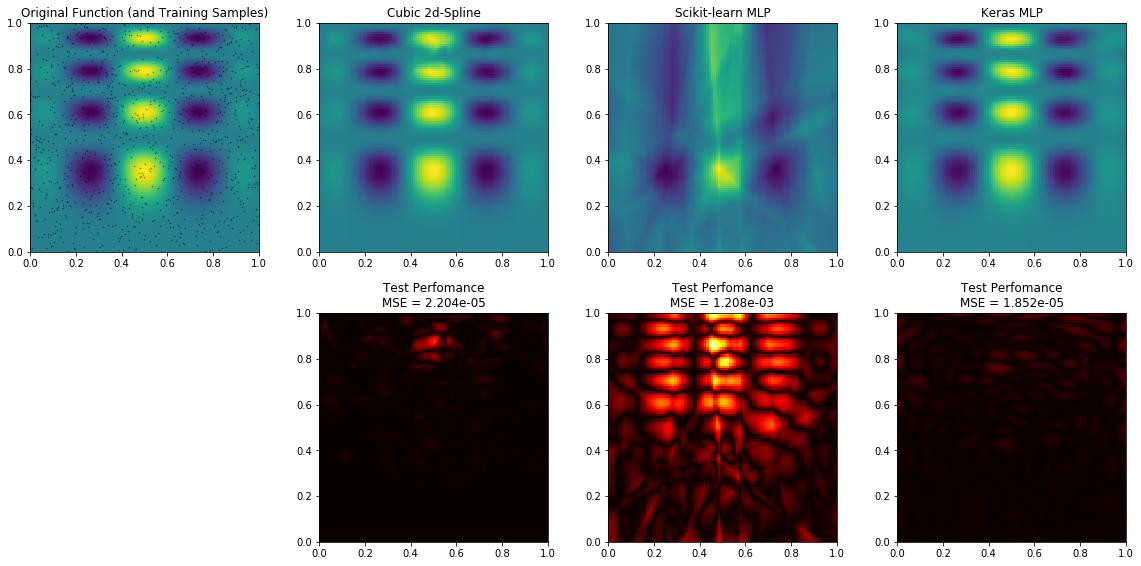

In [10]:
plt.figure(figsize=(16, 8))
# ---
plt.subplot(241)
plt.imshow(func(*np.mgrid[0:1:1000j, 0:1:1000j]).T, extent=(0,1,0,1), origin='lower')
plt.plot(X_train[:,0], X_train[:,1], 'k.', ms=1, alpha=0.5)
plt.title("Original Function (and Training Samples)")
# ---
plt.subplot(242)
plt.imshow(res_griddata.T, extent=(0,1,0,1), origin='lower')
plt.title('Cubic 2d-Spline')

plt.subplot(246)
plt.imshow(error_griddata,  extent=(0,1,0,1), origin='lower', cmap='hot', vmin = _min, vmax = _max)
plt.title(f"Test Perfomance\nMSE = {mean_squared_error(res_griddata.reshape(*y_test.shape), y_test):.3e}")
# ---
plt.subplot(243)
plt.imshow(res_sklearn.T, extent=(0,1,0,1), origin='lower')
plt.title("Scikit-learn MLP")

plt.subplot(247)
plt.imshow(error_scikit, extent=(0,1,0,1), origin='lower',  cmap='hot', vmin = _min, vmax = _max)
plt.title(f"Test Perfomance\nMSE = {mean_squared_error(scikit_model.predict(X_test), y_test):.3e}")
# ---
plt.subplot(244)
plt.imshow(res_keras.T, extent=(0,1,0,1), origin='lower')
plt.title("Keras MLP")

plt.subplot(248)
plt.imshow(error_keras, extent=(0,1,0,1), origin='lower',  cmap='hot', vmin = _min, vmax = _max)
plt.title(f"Test Perfomance\nMSE = {mean_squared_error(keras_model.predict(X_test), y_test):.3e}")
# ---
plt.tight_layout()